In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from sklearn.cluster import KMeans

In [127]:
# call on image pre-processing

def img_seg(path, verbose=False):
  
  def preprocess_helper(raw_img):
    # gray scale and histogram equalization
    #img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
    #img = cv2.equalizeHist(img)
    
    img = raw_img
    
    return img
  
  # load image
  raw_img = cv2.imread(path)
  
  # preprocess image with histogram equalization
  pre_img = preprocess_helper(raw_img)
  
  # get green image channel as the one with the most contrast
  green_img = pre_img[:,:,1]
  
  # convert green_img to float
  green_img_float = green_img.astype(np.float32)/255.0
  
  # remember the shape of the channel/image
  green_shape = green_img_float.shape
  
  # vectorize green channel
  vec = green_img_float.reshape((-1,1))
  
  # start with 3 clusters:
  # 1. background
  # 2. non-target cells
  # 3. target cells
  km = KMeans(n_clusters=3, random_state=0, init="k-means++", n_init="auto").fit(vec)
  labs = np.unique(km.labels_)
  
  # pick the cluster with highest green intensity (darkest)
  cl = labs[np.argmax([ np.mean(vec[km.labels_ == lab]) for lab in labs ])]
  
  if verbose: print("Run 1 k-means cluster with max green intensity:", cl)
  
  # create mask for highest intensity cluster
  mask = np.ones(vec.shape)
  
  mask[(km.labels_ == cl)] = 0
  mask = mask.reshape(green_shape)
  
  # perform second segmentation of cells and nucleus
  sub_green_img = green_img_float[mask == 1].copy()
  #green_img_part2[mask == 1] = green_img_float[mask == 1]
  
  # vectorize green channel
  vec2 = sub_green_img.reshape((-1,1))
  
  # start with 2 clusters:
  # 1. cell outer
  # 3. nucleus
  km2 = KMeans(n_clusters=2, random_state=0, init="k-means++", n_init="auto").fit(vec2)
  labs2 = np.unique(km2.labels_)
  
  # pick the cluster with the highest intensity
  cl2 = labs2[np.argmax([ np.mean(vec2[km2.labels_ == lab]) for lab in labs2 ])]
  
  if verbose: print("Run 2 k-means cluster with max green intensity:", cl2)
  
  # create mask for highest intensity cluster
  mask2 = np.zeros(vec.shape)
  mask2[(km.labels_ != cl)] = 1
  mask2[np.where(km.labels_ != cl)[0][km2.labels_ != cl2]] = 0.5
  
  mask2 = mask2.reshape(green_shape)
  
  # perform second segmentation of cells and nucleus
  #green_img_part2 = np.ones(green_shape)
  #green_img_part2[mask == 1] = green_img_float[mask == 1]

  if verbose:
    fig, axs = plt.subplots(4,1,figsize=(5,15))
    axs[0].imshow(raw_img.astype(np.float32)/255.0)
    #axs[0].title.set_text("/".join(p.split('/')[-2:]))
    axs[0].axis('off')
    axs[1].imshow(green_img_float, cmap='gray')
    #axs[1].title.set_text("/".join(p.split('/')[-2:]))
    axs[1].axis('off')
    axs[2].imshow(mask, cmap='gray')
    #axs[2].title.set_text("/".join(p.split('/')[-2:]))
    axs[2].axis('off')
    axs[3].imshow(mask2, cmap='gray')
    #axs[3].title.set_text("/".join(p.split('/')[-2:]))
    axs[3].axis('off')

    plt.show()
  
  
  
  
  

Run 1 k-means cluster with max green intensity: 0
Run 2 k-means cluster with max green intensity: 0


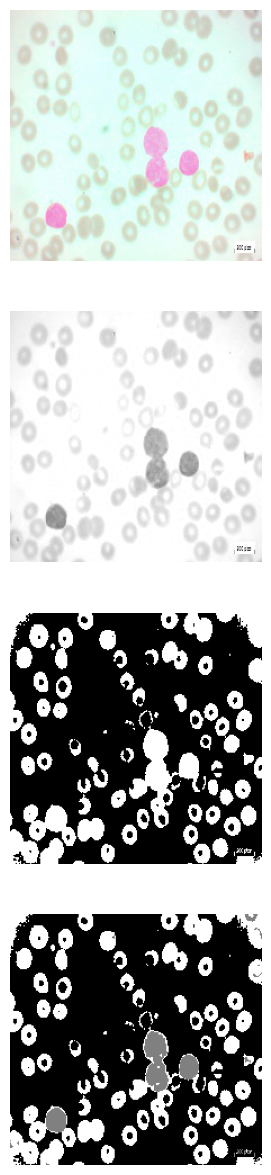

In [133]:
img_seg('data/train/Pro/001.jpg', verbose=True)

In [38]:
# define base path and Path objects for different image sets
img_path_base = 'data/'
path_train = Path(img_path_base) / 'train/'
path_valid = Path(img_path_base) / 'valid/'
path_test = Path(img_path_base) / 'test/'

train_labels = [ pobj.parts[-1].lower() for pobj in path_train.iterdir() if pobj.is_dir() ]
print("Labels: ", train_labels)

Labels:  ['early', 'pro', 'benign', 'pre']


In [39]:
# image paths for each set
train_set = sorted([ pobj for dobj in train_labels for pobj in (path_train / dobj.title()).iterdir() if (
  pobj.is_file() and str(pobj).endswith('.jpg')) ])

valid_set = sorted([ pobj for dobj in train_labels for pobj in (path_valid / dobj.title()).iterdir() if (
  pobj.is_file() and str(pobj).endswith('.jpg')) ])

test_set = sorted([ pobj for dobj in train_labels for pobj in (path_test / dobj.title()).iterdir() if (
  pobj.is_file() and str(pobj).endswith('.jpg')) ])

In [40]:
# create temp verification set for preprocessing
ver_set = [ str(pobj) for pobj in train_set if pobj.parts[-1] in ['001.jpg','002.jpg'] ]
ver_set

['data/train/Benign/001.jpg',
 'data/train/Benign/002.jpg',
 'data/train/Early/001.jpg',
 'data/train/Early/002.jpg',
 'data/train/Pre/001.jpg',
 'data/train/Pre/002.jpg',
 'data/train/Pro/001.jpg',
 'data/train/Pro/002.jpg']

In [41]:
# read images, convert to [0, 1] floats
imgs = [ cv2.imread(sobj).astype(np.float32) / 255.0 for sobj in ver_set ]
print("Images value range:",(np.min(imgs[0]), np.max(imgs[0])))

Images value range: (0.039215688, 1.0)


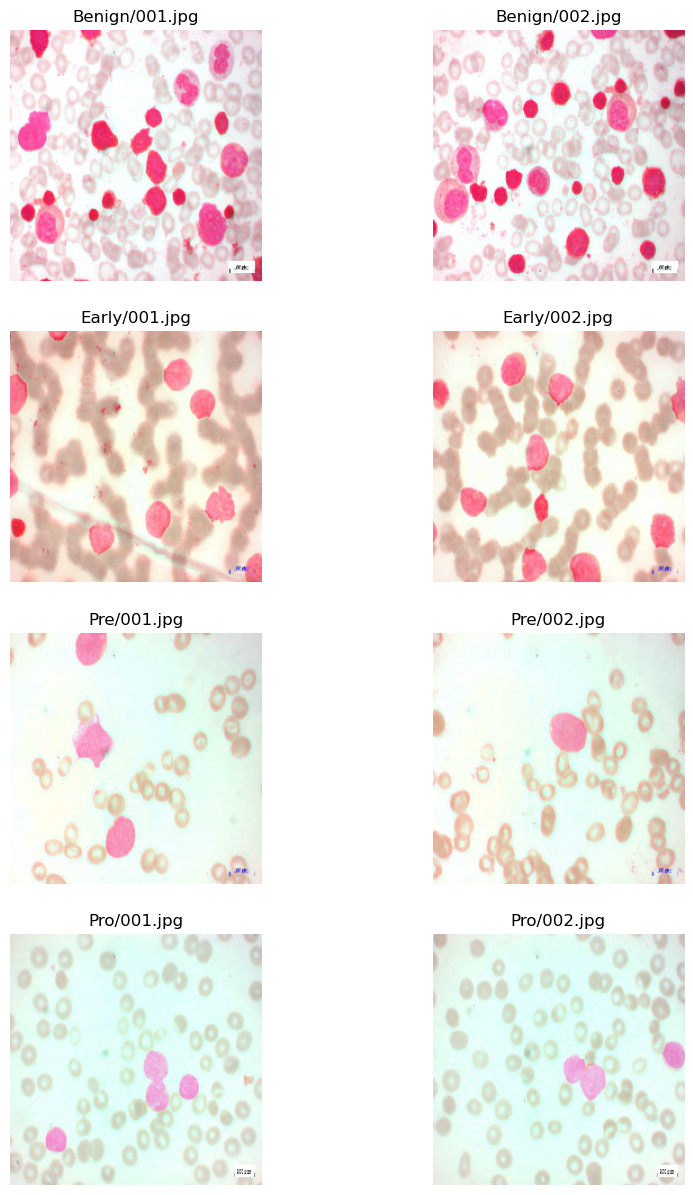

In [42]:
fig, axs = plt.subplots(4,2,figsize=(10,15))
for i, p in enumerate(ver_set):
  axs[i//2,i%2].imshow(imgs[i])
  axs[i//2,i%2].title.set_text("/".join(p.split('/')[-2:]))
  axs[i//2,i%2].axis('off')
  
plt.show()

In [43]:
# pre-process images
proc_imgs = [ img_seg(img_path) for img_path in ver_set ]  

TypeError: Image data of dtype object cannot be converted to float

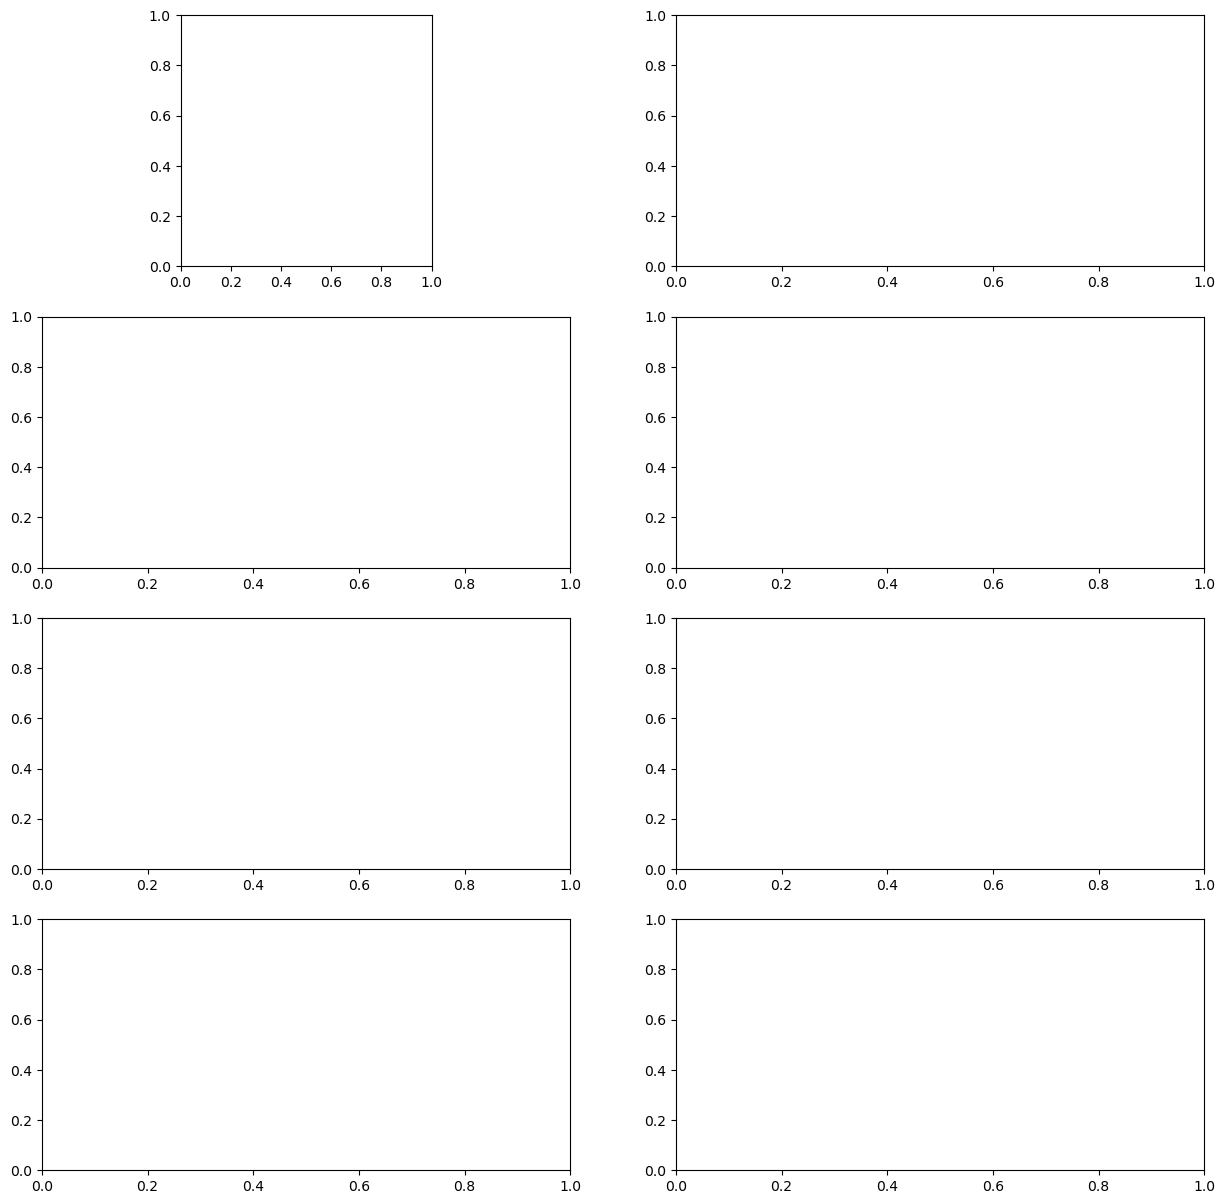

In [44]:
fig, axs = plt.subplots(4,2,figsize=(15,15))
for i, p in enumerate(ver_set):
  axs[i//2,i%2].imshow(proc_imgs[i], cmap='gray')
  axs[i//2,i%2].title.set_text("/".join(p.split('/')[-2:]))
  axs[i//2,i%2].axis('off')
  
plt.show()